In [8]:
from torch_geometric.datasets import ZINC, PPI
from torch_geometric.loader import DataLoader

import torch_geometric.transforms as T
from SPD_encoder import AddShortestPathMatrix, SPDEncoder, RemoveFeatures
import os.path as osp

from torch_geometric.nn import GINEConv, GPSConv
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt

path = osp.join('data', 'ZINC-SPD')  
print("Data path:", path)

# Define transforms
pre_transform = T.Compose([AddShortestPathMatrix(), T.AddRandomWalkPE(20, attr_name='rwpe')])
transform = T.Compose([RemoveFeatures()])
# Load datasets
# train_dataset = ZINC(path, subset=True, split='train', pre_transform=pre_transform, transform=transform)[:5]
PPI_train_dataset = PPI(osp.join('data', 'PPI-SPD')  , split='train', pre_transform=pre_transform, transform=transform)
PPI_val_dataset = PPI(osp.join('data', 'PPI-SPD')  , split='val', pre_transform=pre_transform, transform=transform)

train_loader = DataLoader(PPI_train_dataset, batch_size=20, shuffle=False)
val_loader = DataLoader(PPI_val_dataset, batch_size=1, shuffle=False)

# data = train_dataset[0]
# data = PPI_val_dataset[0]
data = PPI_val_dataset[0]
batch = data

model = SPDEncoder()
# model.load_state_dict(torch.load('model_weights_20231103_0112.pth'))
# model.load_state_dict(torch.load('model_weights_20231110_0204.pth'))
model.load_state_dict(torch.load('model_weights_20231114_2107.pth'))

model.eval()
data

Data path: data/ZINC-SPD


Data(edge_index=[2, 97446], spd=[10432900, 1], rwpe=[3230, 20], num_nodes=3230)

In [15]:
for g in PPI_val_dataset:
    print(g, g.has_isolated_nodes())
    print(g.spd.min(), g.spd.max())

Data(edge_index=[2, 97446], spd=[10432900, 1], rwpe=[3230, 20], num_nodes=3230) True
tensor(0.) tensor(inf)
Data(edge_index=[2, 101474], spd=[10784656, 1], rwpe=[3284, 20], num_nodes=3284) False
tensor(0.) tensor(1.)


In [ ]:
i = 0
j = 3
print(embeddings[i])
print(embeddings[j])
# model.node_pairs_similarity(embeddings)
# model.node_pairs_similarity(embeddings[i], embeddings[j], selected_indices=torch.tensor([[2], [3]]))
selected_indices=torch.tensor([[2], [3]])
z1 = embeddings[selected_indices[0]]  # Shape (num_pairs, embedding_dim)
z2 = embeddings[selected_indices[1]]  # Shape (num_pairs, embedding_dim)

# Calculate pairwise distances only for selected pairs
distance_vector = torch.norm(z1 - z2, dim=-1, p=2)  # Shape (num_pairs,)

# Apply the radial basis function (RBF) kernel to the distance vector
gamma = 0.015625  # This value can be adjusted as needed
rbf_kernel_vector = torch.exp(-gamma * distance_vector.pow(2))

In [26]:
# loss
model.eval()
total_loss = 0
total_count_pairs = 0
for batch in val_loader:
    embeddings = model(batch.rwpe, batch.edge_index, batch.batch)
    loss, count_pairs = model.batch_loss(embeddings, batch.spd, batch.ptr, batch.batch_size, max_pairs_per_graph=6400)
    print(round(loss.item(),4), count_pairs, round(loss.item()/count_pairs,4),sep='\t')
    total_loss += loss.item()
    total_count_pairs += count_pairs
print(round(total_loss/total_count_pairs,4))

83.5987	6400	0.0131
136.6822	6400	0.0214
0.0172


In [13]:
import scipy.sparse.csgraph as csgraph

edge_index = data.edge_index.cpu().numpy()
num_nodes = data.num_nodes
# adj
adjacency_matrix = np.zeros((num_nodes, num_nodes)) # type: ignore
adjacency_matrix[edge_index[0], edge_index[1]] = 1
# spd
shortest_path_matrix = csgraph.floyd_warshall(adjacency_matrix)
# diameter
diameter = np.max(shortest_path_matrix[shortest_path_matrix != np.inf])
assert diameter > 0
# normalize
shortest_path_matrix = shortest_path_matrix / diameter

# data.spd = torch.tensor(shortest_path_matrix.reshape(-1, 1), dtype=torch.float).to(data.edge_index.device)

In [15]:
import numpy as np
 

embeddings = model(data.rwpe, data.edge_index, data.batch)
# not normalized
# for i in range(data.num_nodes):
#     print(i, round(1 / model.node_pairs_similarity(embeddings)[0][i].item(), 2), data.spd.reshape(data.num_nodes, data.num_nodes)[0][i].item(), sep='\t')
def map_score(x,lambda_=3):
    # (torch.exp(- lambda_ * spd_matrix) - torch.exp(- lambda_)) * ( 1/(1 - torch.exp(- lambda_)))
    # return (torch.exp(- lambda_ * x) - torch.exp(- lambda_)) * ( 1/(1 - torch.exp(- lambda_)))
    # numpy
    return (np.exp(- lambda_ * x) - np.exp(- lambda_)) * ( 1/(1 - np.exp(- lambda_)))
# normalized
loss = 0.0
for i in range(0, data.num_nodes, 1):
    # print(i, round(model.node_pairs_similarity(embeddings)[0][i].item(), 2), data.spd.reshape(data.num_nodes, data.num_nodes)[0][i].item(), sep='\t')
    sim_pred = model.node_pairs_similarity(embeddings)[0][i].item()
    sim_true = map_score(data.spd.reshape(data.num_nodes, data.num_nodes)[0][i].item())
    # if sim_true < 0.3:
    #     continue
    loss = torch.nn.functional.mse_loss(torch.tensor(sim_pred), torch.tensor(sim_true))
    print(i, round(sim_pred, 6), round(sim_true, 6), data.spd.reshape(data.num_nodes, data.num_nodes)[0][i].item(),round(loss.item(), 6) ,sep='\t')
    
    # print(loss)
# print(1 / model.node_pairs_similarity(embeddings)[0])
# print(data.spd.reshape(data.num_nodes, data.num_nodes)[0])

0	1.0	1.0	0.0	0.0
1	0.755953	0.238542	0.4285714328289032	0.267714
2	0.995758	0.394212	0.2857142984867096	0.361857
3	0.941509	0.394212	0.2857142984867096	0.299534
4	0.55398	0.238542	0.4285714328289032	0.099501
5	0.963174	0.238542	0.4285714328289032	0.525091
6	0.970129	0.394212	0.2857142984867096	0.331679
7	0.951565	0.238542	0.4285714328289032	0.508401
8	0.907055	0.238542	0.4285714328289032	0.44691
9	0.944574	0.238542	0.4285714328289032	0.498481
10	0.771298	0.394212	0.2857142984867096	0.142193
11	0.799397	0.394212	0.2857142984867096	0.164174
12	0.893667	0.238542	0.4285714328289032	0.429188
13	0.99565	0.238542	0.4285714328289032	0.573212
14	0.973951	0.238542	0.4285714328289032	0.540826
15	0.322197	0.394212	0.2857142984867096	0.005186
16	0.406134	0.238542	0.4285714328289032	0.028087
17	0.9784	0.238542	0.4285714328289032	0.54739
18	0.984348	0.394212	0.2857142984867096	0.34826
19	0.406134	0.238542	0.4285714328289032	0.028087
20	0.995768	0.394212	0.2857142984867096	0.361869
21	0.432259	0.2385

KeyboardInterrupt: 

In [18]:
(0.755953-0.238542)**2

0.26771414292099993

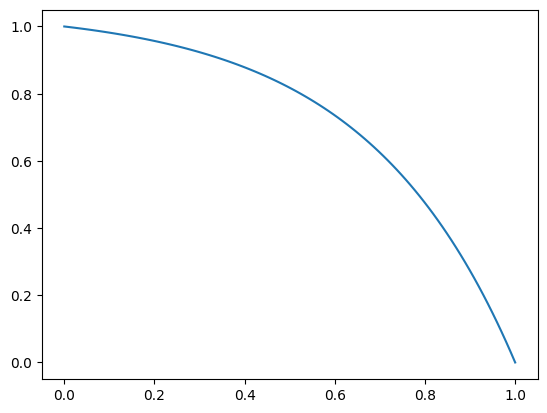

In [46]:
x = np.linspace(0, 1, 100)
# map_score(x, lambda_=3)
plt.plot(x, map_score(x, lambda_=-3))

In [ ]:
import scipy.sparse.csgraph as csgraph

edge_index = data.edge_index.cpu().numpy()
num_nodes = data.num_nodes
# adj
adjacency_matrix = np.zeros((num_nodes, num_nodes)) # type: ignore
adjacency_matrix[edge_index[0], edge_index[1]] = 1
# spd
shortest_path_matrix = csgraph.floyd_warshall(adjacency_matrix)
# diameter
diameter = np.max(shortest_path_matrix[shortest_path_matrix != np.inf])

In [ ]:
shortest_path_matrix[:20, :20]

In [ ]:
diameter

1767
0.125 1.0


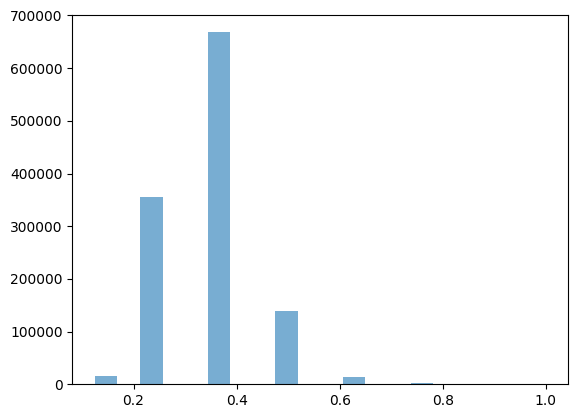

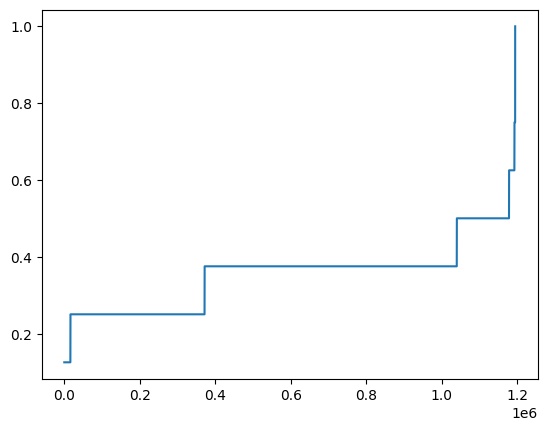

In [24]:
# data.spd.reshape(data.num_nodes, data.num_nodes)
# 观察其上三角的分布
print(data.num_nodes)
triu_indices = torch.triu_indices(data.num_nodes, data.num_nodes, offset=1)
spd_values= data.spd.reshape(data.num_nodes, data.num_nodes)[triu_indices[0], triu_indices[1]].numpy()
# drop inf
spd_values = spd_values[spd_values != np.inf]
# range
print(spd_values.min(), spd_values.max())
plt.hist(spd_values , bins=20, alpha=0.6)
# legend
plt.show()
# print(spd_values.shape)
plt.plot(sorted(spd_values))
plt.show()

In [ ]:
# visualize the graph
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())
nx.draw(G, with_labels=False, node_size=0.5, alpha=0.5, width=0.05, pos=nx.spring_layout(G))
plt.show()
data

In [ ]:
# visualize the graph
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())
nx.draw(G, with_labels=True, pos=nx.spring_layout(G,seed=42))
plt.show()


In [ ]:
# visualize embeddings use TSNE
from cgitb import text
from sklearn.manifold import TSNE
import numpy as np
seed = 0
np.random.seed(seed)
X = embeddings.detach().numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=np.arange(data.num_nodes), cmap='tab10')
# node id 
for i in range(X_embedded.shape[0]):
    plt.annotate(i, (X_embedded[i, 0], X_embedded[i, 1]))
plt.show()